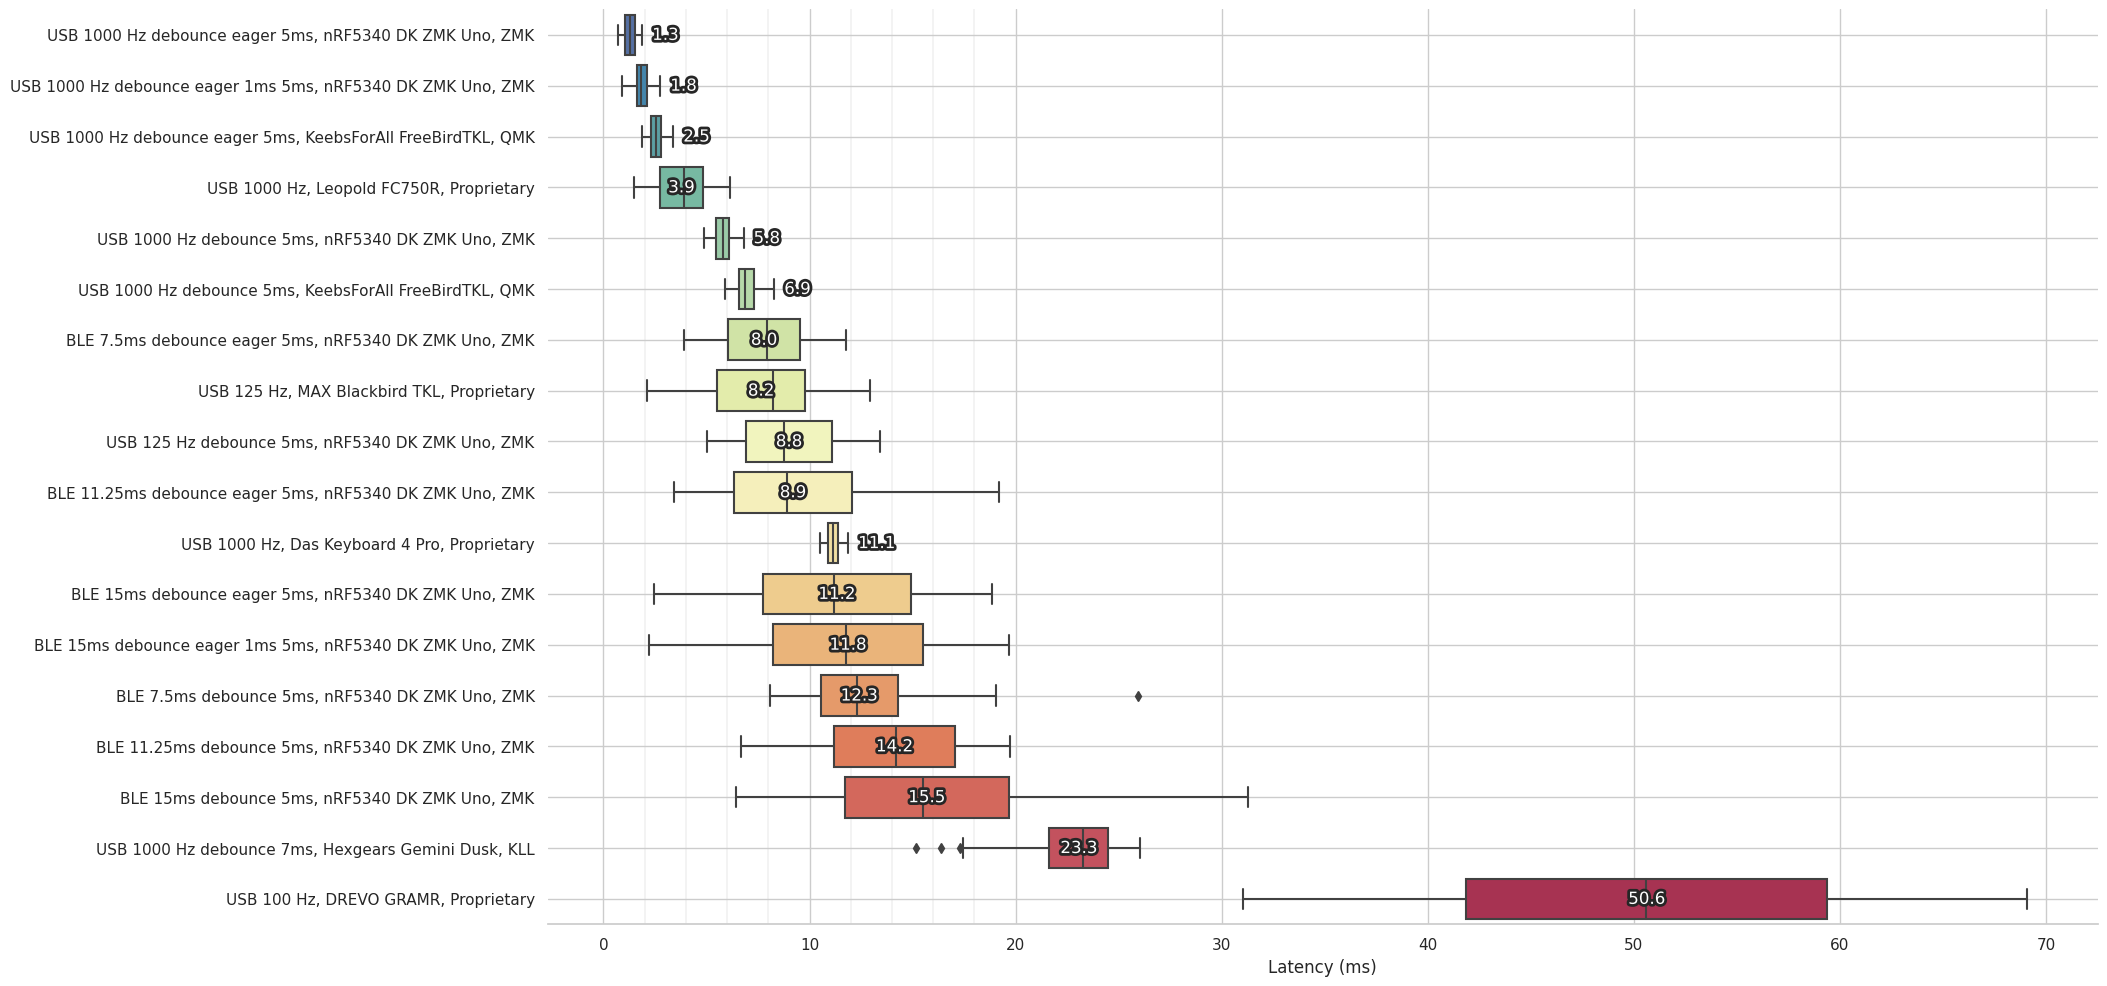

In [28]:
from dataclasses import dataclass
from itertools import chain
from pathlib import Path
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import pandas as pd
import seaborn as sns

RESULTS_DIR = Path().resolve()
NAME_REPLACEMENTS = {
    r"[-_]+": " ",
    r"ble": "BLE",
    r"usb": "USB",
    r"(?<=\d)hz": " Hz",
}
CHART_WIDTH = 20
ROW_HEIGHT = 0.66


@dataclass
class Sample:
    firmware: str
    keyboard: str
    settings: str
    latency: float


def cleanup_filename(name: str):
    for pattern, replacement in NAME_REPLACEMENTS.items():
        name = re.sub(pattern, replacement, name)

    return name


def get_file_metadata(path: Path) -> tuple[str, str, str]:
    relative_path = path.relative_to(RESULTS_DIR)
    parts = relative_path.with_suffix("").parts
    if len(parts) != 3:
        raise Exception(
            f'Expected "results/firmware/keyboard/settings.csv" but got {relative_path}'
        )

    return (cleanup_filename(x) for x in parts)


def get_data():
    def read_csv(path: Path):
        firmware, keyboard, settings = get_file_metadata(path)
        data = pd.read_csv(path)["Latency (ms)"]
        return [Sample(firmware, keyboard, settings, latency) for latency in data]

    csv_files = RESULTS_DIR.rglob("*.csv")
    return pd.DataFrame(chain.from_iterable(read_csv(csv) for csv in csv_files))


def chunks(iterable, n):
    args = [iter(iterable)] * n
    return zip(*args)


def get_x_size(ax: plt.Axes, window_size: float):
    coords = ax.transData.inverted().transform_affine([(0, 0), (window_size, 0)])
    return coords[1][0] - coords[0][0]


def get_line_x(line: plt.Line2D):
    try:
        return line.get_xdata()[0]
    except IndexError:
        return 0


def add_median_text(fig: plt.Figure, ax: plt.Axes):
    renderer = fig.canvas.get_renderer()
    color = mpl.rcParams["figure.facecolor"]
    stroke = mpl.rcParams["xtick.color"]
    effects = [patheffects.Stroke(linewidth=4, foreground=stroke), patheffects.Normal()]
    padding = get_x_size(ax, 10)

    lines_x = [get_line_x(line) for line in ax.get_lines()]

    for row, patch, lines in zip(ax.get_yticks(), ax.patches, chunks(lines_x, 6)):
        left_x, right_x, _, whisker_x, median_x, _ = lines

        x = (left_x + right_x) / 2
        median = f"{median_x:0.1f}"

        text = ax.text(x, row, median, ha="center", va="center", color=color)
        text.set_clip_on(True)
        text.set_path_effects(effects)

        # Shift text to the side if it won't fit inside the bar.
        text_bb = text.get_window_extent(renderer)
        patch_bb = patch.get_window_extent(renderer)

        if text_bb.width > patch_bb.width * 0.8:
            text.set_x(whisker_x + padding)
            text.set_horizontalalignment("left")


grouped = get_data().groupby(["settings", "keyboard", "firmware"])
df = pd.DataFrame({", ".join(col): vals["latency"] for col, vals in grouped})
medians = df.median().sort_values()

# Chart
n_rows = len(df.keys())
fig, ax = plt.subplots(figsize=(CHART_WIDTH, n_rows * ROW_HEIGHT))

sns.set_theme(style="whitegrid")
sns.boxplot(ax=ax, data=df[medians.index], orient="h", palette="Spectral_r")
sns.despine(left=True, right=True, top=True)

# X axis
ax.set_axisbelow(True)
ax.set_xlabel("Latency (ms)")
ax.set_xticks(range(0, 20, 2), minor=True)
ax.xaxis.grid(True)
ax.xaxis.grid(True, which="minor", linewidth=0.33)

# Y axis
ax.yaxis.grid(True)

add_median_text(fig, ax)


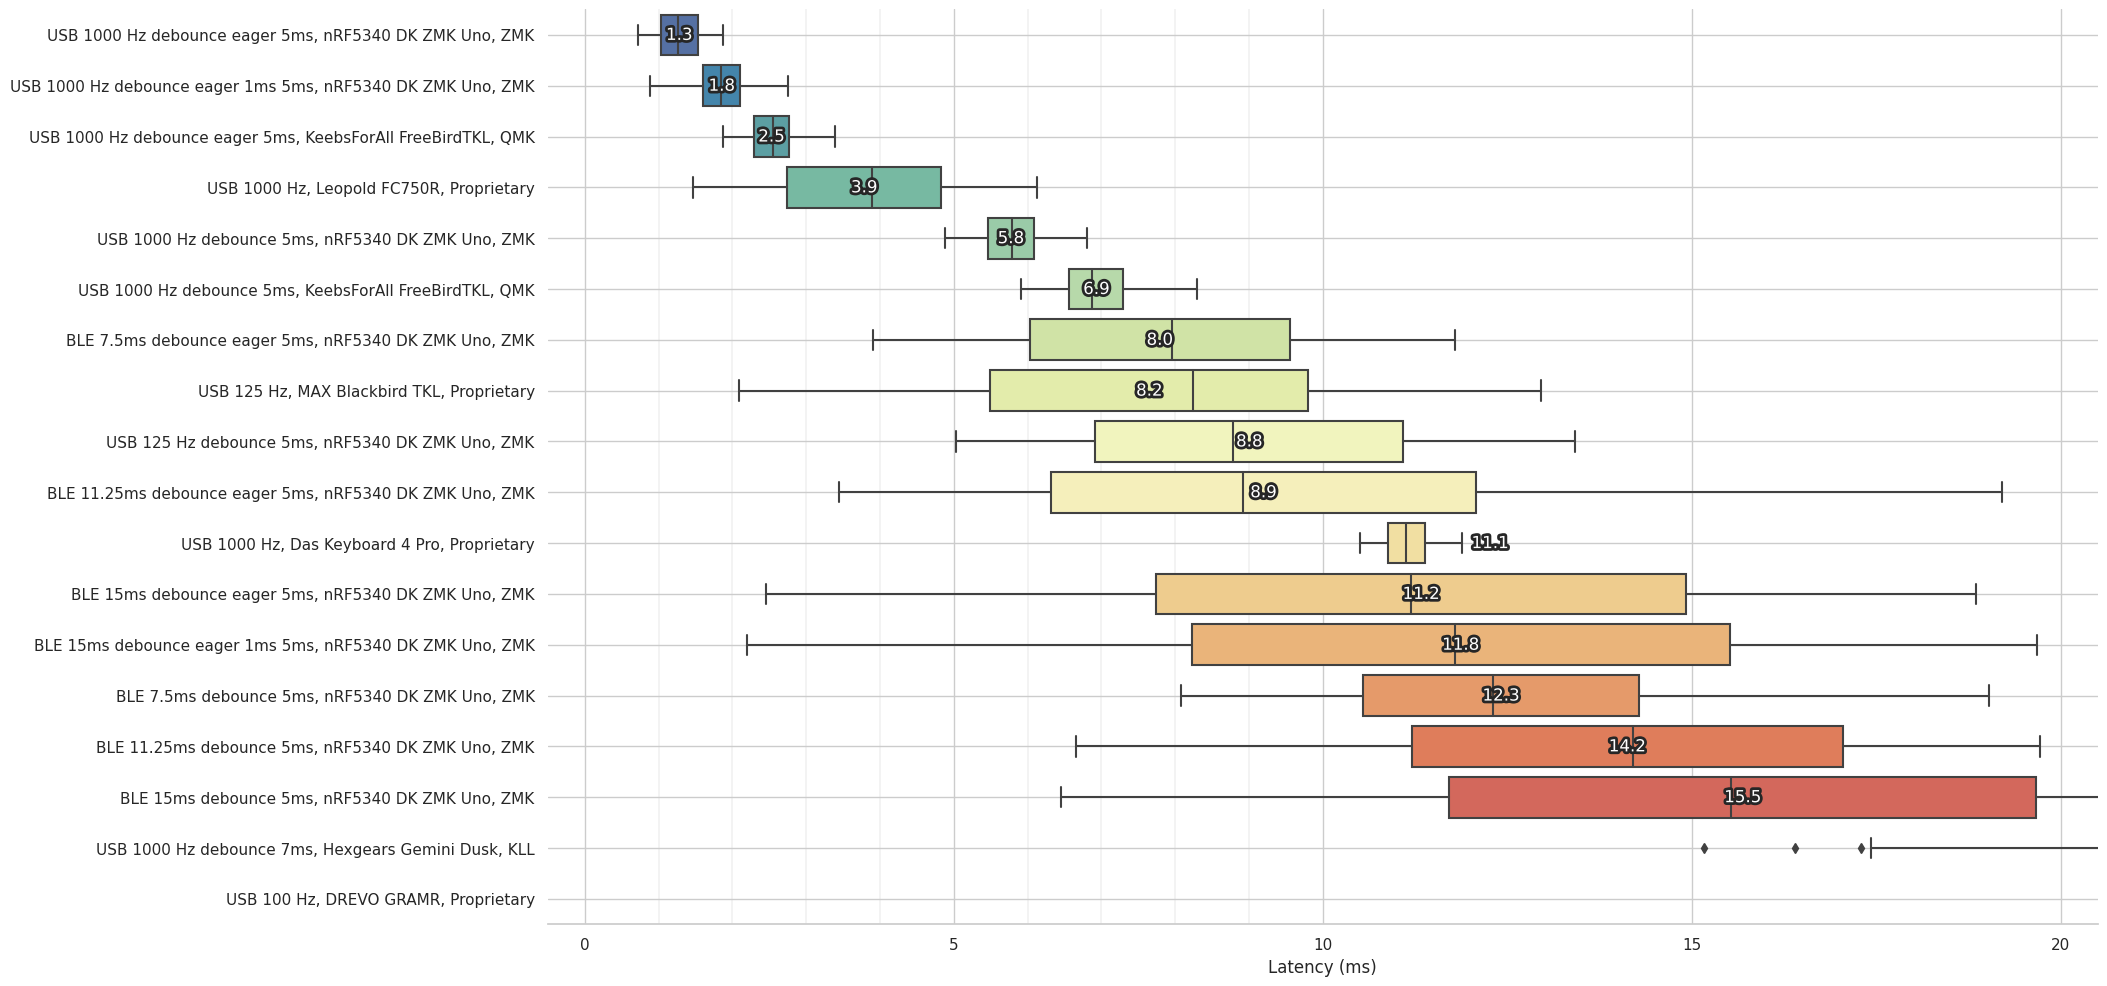

In [27]:
# Zoom chart to [0, 20] ms
ax.set_xlim(-0.5, 20.5)
ax.set_xticks(range(0, 25, 5))
ax.set_xticks(range(0, 10, 1), minor=True)

for text in ax.texts:
    text.remove()

add_median_text(fig, ax)
fig